- NVIDIA GeForce GTX 1060 6GB
- Pytorch 1.4.0
- model EfficientNet-B3
- image size 128x128
- batch size 64
- 0-folds
- 10 epochs
- augmentation rotate 4.5
- optimizer over 9000
- one cycle learning rate

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import gc
import cv2
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import warnings
warnings.filterwarnings("ignore")

from crop_resize import read_feathers

In [2]:
model_name = 'efficientnet-b3'
pretrained_model_name = './20200308_fold0_no_aug_0-1/efficientnet-b3_29.pth'
image_size = 128
batch_size = 72
random_state = 2020
n_epochs = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

in_dir = Path('../input/bengaliai-cv19')
feather_dir = Path('../input/bengaliai-cv19-feather')
out_dir = Path('./20200309_rotate')

cuda:0


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 2020
seed_everything(SEED)

<a id="images"></a>
# Images

In [4]:
filenames = [feather_dir/f'train_image_data_1x{image_size}x{image_size}_{i}.feather' for i in range(4)]
images = read_feathers(filenames, image_size)
print(images.shape)

(200840, 1, 128, 128)


<a id="labels"></a>
# Labels

In [5]:
train_label = pd.read_csv(in_dir/'train.csv')
labels = train_label[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
print(labels.shape)

(200840, 3)


<a id="dataset"></a>
# Dataset

In [6]:
from torch.utils.data import Dataset

class GraphemeDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.train = labels is not None
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = image / image.max()
        if self.transform:
            image_size = image.shape[1]
            image = self.transform(image=image[0])['image']
            image = image.reshape(-1, image_size, image_size)
        if self.train:
            label = self.labels[idx]
            return image, label[0], label[1], label[2]
        else:
            return image

In [7]:
train_dataset = GraphemeDataset(images, labels)
print(len(train_dataset))

200840


<a id="visualize"></a>
# Visualize

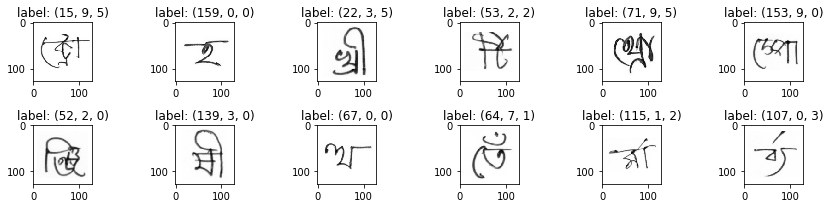

In [8]:
nrow, ncol = 2, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 3))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, label1, label2, label3 = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label1, label2, label3}')
plt.tight_layout()
plt.show()

<a id="transform"></a>
# Transform

In [9]:
from albumentations import Compose, Rotate
# reference
# https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/migrating_from_torchvision_to_albumentations.ipynb

albumentations_transform = Compose([
    Rotate(limit=0.05*90, p=0.5),
])

train_dataset = GraphemeDataset(images, labels, albumentations_transform)
print(len(train_dataset))

200840


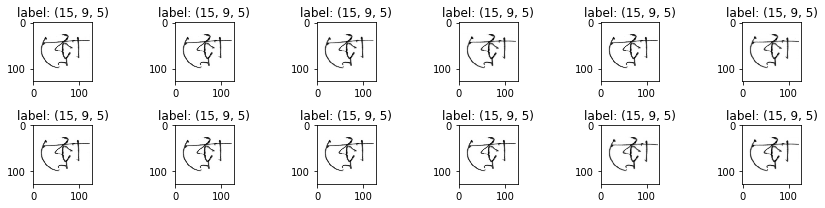

In [10]:
nrow, ncol = 2, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 3))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, label1, label2, label3 = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label1, label2, label3}')
plt.tight_layout()
plt.show()

<a id="dataloader"></a>
# DataLoader

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print('train loader length', len(train_loader))

train loader length 2790


<a id="model"></a> 
# Model

In [12]:
from my_efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained(model_name, in_channels=1).to(device)
model.load_state_dict(torch.load(pretrained_model_name))

Loaded pretrained weights for efficientnet-b3


<All keys matched successfully>

<a id="optimizer"></a> 
# Optimizer

In [13]:
from optimizer.ralamb import Ralamb
from optimizer.lookahead import Lookahead

def Over9000(params, alpha=0.5, k=6, *args, **kwargs):
     ralamb = Ralamb(params, *args, **kwargs)
     return Lookahead(ralamb, alpha, k)

In [14]:
optimizer =Over9000(model.parameters(), lr=2e-3, weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, total_steps=None, epochs=n_epochs, 
                                                steps_per_epoch=len(train_loader), pct_start=0.0, anneal_strategy='cos', 
                                                cycle_momentum=True, base_momentum=0.85, max_momentum=0.95,  div_factor=100.0)

<a id="loss"></a> 
# loss

In [15]:
from torch import nn

criterion = nn.CrossEntropyLoss()

<a id="metrics"></a> 
# Metrics

In [16]:
from metrics import macro_recall_multi

<a id="train"></a> 
# Train

In [17]:
history = pd.DataFrame()

for epoch in range(n_epochs):
    
    # --- training start ---
    torch.cuda.empty_cache()
    gc.collect()
    
    running_loss1, running_loss2, running_loss3 = 0.0, 0.0, 0.0
    running_acc1, running_acc2, running_acc3 = 0.0, 0.0, 0.0
    running_recall = 0.0
    
    train_loss1, train_loss2, train_loss3 = 0.0, 0.0, 0.0
    train_acc1, train_acc2, train_acc3 = 0.0, 0.0, 0.0
    train_loss, train_acc, train_recall = 0.0, 0.0, 0.0
    
    model.train()
    
    # training loop
    for idx, (inputs, labels1, labels2, labels3) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # to GPU
        #inputs, labels1, labels2, labels3 = inputs.to(device), labels1.to(device), labels2.to(device), labels3.to(device)
        inputs, labels1, labels2, labels3 = inputs.float().to(device), labels1.to(device), labels2.to(device), labels3.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward (on GPU)
        #outputs1, outputs2, outputs3 = model(inputs.unsqueeze(1).float())
        outputs1, outputs2, outputs3 = model(inputs)
        
        # loss
        loss1 = criterion(outputs1, labels1)
        loss2 = criterion(outputs2, labels2)
        loss3 = criterion(outputs3, labels3)
        running_loss1 += loss1.item()
        running_loss2 += loss2.item()
        running_loss3 += loss3.item()
        
        # accuracy
        running_acc1 += (outputs1.argmax(1)==labels1).float().mean()
        running_acc2 += (outputs2.argmax(1)==labels2).float().mean()
        running_acc3 += (outputs3.argmax(1)==labels3).float().mean()
        
        # recall
        running_recall += macro_recall_multi(outputs1, labels1, outputs2, labels2, outputs3, labels3)
        
        # backward (on GPU)
        (0.8 * loss1 + 0.1 * loss2 + 0.1 * loss3).backward()
        
        # optimize
        optimizer.step()
        scheduler.step()
    
    # loss, accuracy, recall
    train_loss1 = running_loss1 / len(train_loader)
    train_loss2 = running_loss2 / len(train_loader)
    train_loss3 = running_loss3 / len(train_loader)
    train_loss = 0.5 * train_loss1 + 0.25 * train_loss2 + 0.25 * train_loss3
    train_acc1 = running_acc1 / len(train_loader)
    train_acc2 = running_acc2 / len(train_loader)
    train_acc3 = running_acc3 / len(train_loader)
    train_acc = (train_acc1 + train_acc2 + train_acc3) / 3
    train_recall = running_recall / len(train_loader)
    
    # log
    print('train epoch : {}'.format(epoch))
    print('loss   : {:.4f}, loss1 : {:.4f}, loss2 : {:.4f}, loss3 : {:.4f}'.format(train_loss, train_loss1, train_loss2, train_loss3))
    print('acc    : {:.4f}, acc1  : {:.4f}, acc2  : {:.4f}, acc3  : {:.4f}'.format(train_acc, train_acc1, train_acc2, train_acc3))
    print('recall : {:.4f}'.format(train_recall))
    
    # history
    history.loc[epoch, 'train/loss'] = train_loss
    history.loc[epoch, 'train/loss1'] = train_loss1
    history.loc[epoch, 'train/loss2'] = train_loss2
    history.loc[epoch, 'train/loss3'] = train_loss3
    history.loc[epoch, 'train/acc'] = train_acc.cpu().numpy()
    history.loc[epoch, 'train/acc1'] = train_acc1.cpu().numpy()
    history.loc[epoch, 'train/acc2'] = train_acc2.cpu().numpy()
    history.loc[epoch, 'train/acc3'] = train_acc3.cpu().numpy()
    history.loc[epoch, 'train/recall'] = train_recall
    history.loc[epoch, 'lr'] = scheduler.get_lr()[0]
    
    torch.save(model.state_dict(), out_dir/f'{model_name}_{epoch}.pth')

history.to_csv(out_dir/'history.csv')


train epoch : 0
loss   : 0.0295, loss1 : 0.0318, loss2 : 0.0268, loss3 : 0.0275
acc    : 0.9910, acc1  : 0.9897, acc2  : 0.9918, acc3  : 0.9914
recall : 0.9845



train epoch : 1
loss   : 0.0485, loss1 : 0.0544, loss2 : 0.0429, loss3 : 0.0425
acc    : 0.9855, acc1  : 0.9826, acc2  : 0.9873, acc3  : 0.9867
recall : 0.9746



train epoch : 2
loss   : 0.0487, loss1 : 0.0523, loss2 : 0.0461, loss3 : 0.0441
acc    : 0.9852, acc1  : 0.9826, acc2  : 0.9866, acc3  : 0.9865
recall : 0.9742



train epoch : 3
loss   : 0.0452, loss1 : 0.0474, loss2 : 0.0439, loss3 : 0.0421
acc    : 0.9863, acc1  : 0.9844, acc2  : 0.9873, acc3  : 0.9871
recall : 0.9760



train epoch : 4
loss   : 0.0411, loss1 : 0.0420, loss2 : 0.0403, loss3 : 0.0402
acc    : 0.9874, acc1  : 0.9862, acc2  : 0.9882, acc3  : 0.9877
recall : 0.9785



train epoch : 5
loss   : 0.0367, loss1 : 0.0353, loss2 : 0.0392, loss3 : 0.0370
acc    : 0.9884, acc1  : 0.9883, acc2  : 0.9884, acc3  : 0.9886
recall : 0.9807



train epoch : 6
loss   : 0.0326, loss1 : 0.0302, loss2 : 0.0353, loss3 : 0.0347
acc    : 0.9896, acc1  : 0.9901, acc2  : 0.9896, acc3  : 0.9892
recall : 0.9831



train epoch : 7
loss   : 0.0279, loss1 : 0.0245, loss2 : 0.0320, loss3 : 0.0308
acc    : 0.9909, acc1  : 0.9920, acc2  : 0.9905, acc3  : 0.9903
recall : 0.9856



train epoch : 8
loss   : 0.0229, loss1 : 0.0193, loss2 : 0.0265, loss3 : 0.0265
acc    : 0.9925, acc1  : 0.9936, acc2  : 0.9920, acc3  : 0.9917
recall : 0.9883



train epoch : 9
loss   : 0.0193, loss1 : 0.0157, loss2 : 0.0233, loss3 : 0.0225
acc    : 0.9936, acc1  : 0.9948, acc2  : 0.9930, acc3  : 0.9929
recall : 0.9899



train epoch : 10
loss   : 0.0154, loss1 : 0.0113, loss2 : 0.0196, loss3 : 0.0192
acc    : 0.9946, acc1  : 0.9962, acc2  : 0.9939, acc3  : 0.9937
recall : 0.9919



train epoch : 11
loss   : 0.0121, loss1 : 0.0082, loss2 : 0.0158, loss3 : 0.0164
acc    : 0.9957, acc1  : 0.9973, acc2  : 0.9949, acc3  : 0.9947
recall : 0.9935



train epoch : 12
loss   : 0.0092, loss1 : 0.0057, loss2 : 0.0126, loss3 : 0.0129
acc    : 0.9966, acc1  : 0.9982, acc2  : 0.9958, acc3  : 0.9958
recall : 0.9953



train epoch : 13
loss   : 0.0069, loss1 : 0.0038, loss2 : 0.0103, loss3 : 0.0098
acc    : 0.9974, acc1  : 0.9989, acc2  : 0.9967, acc3  : 0.9967
recall : 0.9966



train epoch : 14
loss   : 0.0052, loss1 : 0.0028, loss2 : 0.0075, loss3 : 0.0077
acc    : 0.9980, acc1  : 0.9992, acc2  : 0.9976, acc3  : 0.9973
recall : 0.9972



train epoch : 15
loss   : 0.0037, loss1 : 0.0015, loss2 : 0.0057, loss3 : 0.0059
acc    : 0.9986, acc1  : 0.9997, acc2  : 0.9982, acc3  : 0.9981
recall : 0.9982



train epoch : 16
loss   : 0.0028, loss1 : 0.0011, loss2 : 0.0045, loss3 : 0.0044
acc    : 0.9990, acc1  : 0.9998, acc2  : 0.9986, acc3  : 0.9986
recall : 0.9986



train epoch : 17
loss   : 0.0022, loss1 : 0.0008, loss2 : 0.0035, loss3 : 0.0036
acc    : 0.9991, acc1  : 0.9998, acc2  : 0.9989, acc3  : 0.9988
recall : 0.9990



train epoch : 18
loss   : 0.0020, loss1 : 0.0006, loss2 : 0.0032, loss3 : 0.0035
acc    : 0.9993, acc1  : 0.9999, acc2  : 0.9990, acc3  : 0.9989
recall : 0.9990



train epoch : 19
loss   : 0.0018, loss1 : 0.0006, loss2 : 0.0030, loss3 : 0.0030
acc    : 0.9993, acc1  : 0.9999, acc2  : 0.9991, acc3  : 0.9991
recall : 0.9991


In [18]:
history

,train/loss,train/loss1,train/loss2,train/loss3,train/acc,train/acc1,train/acc2,train/acc3,train/recall,lr
0,0.029481,0.031827,0.026762,0.027506,0.990979,0.989715,0.991802,0.991420,0.984462,9.938398e-03
1,0.048533,0.054385,0.042853,0.042510,0.985512,0.982568,0.987279,0.986689,0.974599,9.755196e-03
2,0.048707,0.052323,0.046115,0.044065,0.985197,0.982568,0.986569,0.986455,0.974221,9.454905e-03
3,0.045187,0.047372,0.043920,0.042085,0.986277,0.984433,0.987312,0.987088,0.975987,9.044920e-03
4,0.041133,0.041973,0.040348,0.040237,0.987370,0.986199,0.988168,0.987745,0.978544,8.535336e-03
5,0.036671,0.035274,0.039156,0.036979,0.988427,0.988273,0.988448,0.988562,0.980748,7.938701e-03
6,0.032617,0.030211,0.035326,0.034720,0.989639,0.990131,0.989618,0.989167,0.983110,7.269704e-03
7,0.027938,0.024470,0.032001,0.030813,0.990935,0.991999,0.990510,0.990296,0.985645,6.544821e-03
8,0.022893,0.019310,0.026489,0.026461,0.992471,0.993649,0.992044,0.991721,0.988280,5.781899e-03
9,0.019295,0.015672,0.023316,0.022519,0.993568,0.994816,0.992962,0.992927,0.989859,4.999723e-03


<a id="inference"></a> 
# Inference

In [19]:
from crop_resize import read_parquets

height = 137
width = 236
image_size = 128

filenames = [in_dir/f'test_image_data_{i}.parquet' for i in range(4)]
images = read_parquets(filenames, width, height, image_size)
test_dataset = GraphemeDataset(images)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1500.29it/s]


In [20]:
row_id = []
target = []

model.eval()

with torch.no_grad():
    for idx, inputs in tqdm(enumerate(test_loader), total=len(test_loader)):
        inputs = inputs.float().cuda()
        outputs1, outputs2, outputs3 = model(inputs)
        p1 = outputs1.argmax(-1).view(-1).cpu()
        p2 = outputs2.argmax(-1).view(-1).cpu()
        p3 = outputs3.argmax(-1).view(-1).cpu()
        row_id += [f'Test_{idx}_grapheme_root', f'Test_{idx}_vowel_diacritic', f'Test_{idx}_consonant_diacritic']
        target += [p1.item(), p2.item(), p3.item()]

sub_df = pd.DataFrame({'row_id': row_id, 'target': target})
sub_df.to_csv(out_dir/'submission.csv', index=False)
sub_df

,row_id,target
0,Test_0_grapheme_root,3
1,Test_0_vowel_diacritic,0
2,Test_0_consonant_diacritic,0
3,Test_1_grapheme_root,93
4,Test_1_vowel_diacritic,2
5,Test_1_consonant_diacritic,0
6,Test_2_grapheme_root,19
7,Test_2_vowel_diacritic,0
8,Test_2_consonant_diacritic,0
9,Test_3_grapheme_root,115
